# Beyond IID: Evaluating the Impact of Data Splitting Strategies on Model Performance

## Objective
The objective of this project is to study the impact of data-splitting assumptions on predictive performance. 
While conventional train–test splits assume that samples are independently and identically distributed (IID), this assumption may not hold in practice. 
We therefore compare strong IID splits with weaker, group-aware splits to evaluate their effect on model performance.


## 1. Data Description
The dataset used in this study is the Online News Popularity dataset, which contains information about online news articles and their associated popularity.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [73]:
df = pd.read_csv('OnlineNewsPopularity.csv')

df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [74]:
leak_cols = [
    ' self_reference_min_shares',
    ' self_reference_max_shares',
    ' self_reference_avg_sharess'
]

X = df.drop(columns=leak_cols + [' shares', 'url'])
y = df[' shares']


Since some features are constructed using information that is directly or indirectly derived from the target variable, their inclusion may introduce target leakage. To mitigate this issue, we identify and remove all such related features prior to model training.

## 2. EDA Recap

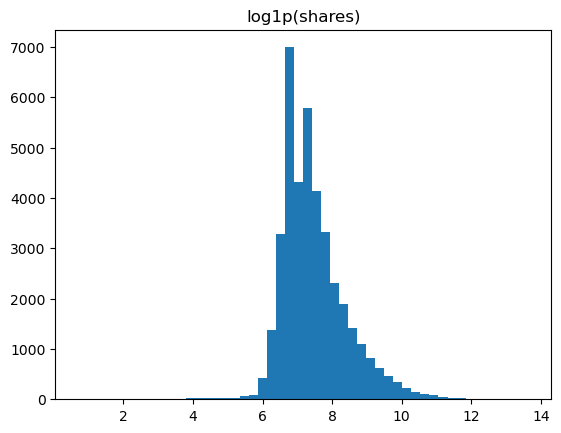

In [75]:
plt.hist(np.log1p(y), bins=50)
plt.title("log1p(shares)")
plt.show()

Extreme values

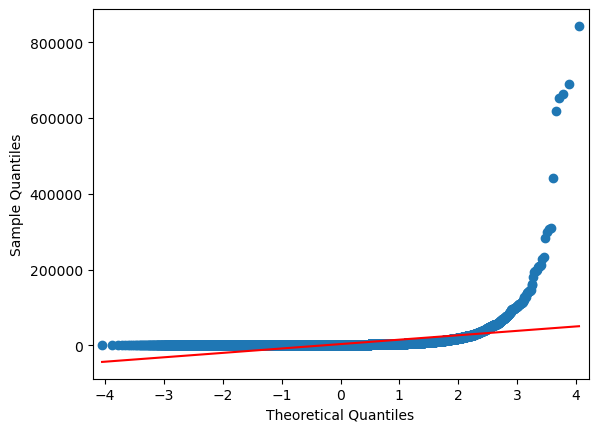

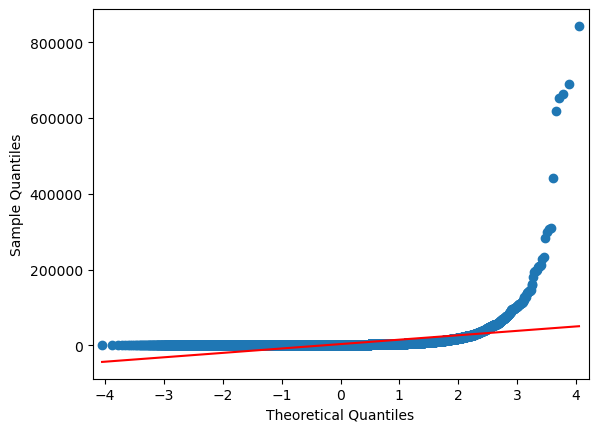

In [76]:
sm.qqplot(y, line='s') 

Given the heavy-tailed nature of the target variable and the presence of extreme values, evaluation metrics under random splits may be highly sensitive to outliers. We therefore use Mean Absolute Error (MAE), which provides a more robust assessment of predictive performance compared to metrics based on squared errors.

## 3. Splitting Strategies

### Strong IID Split

#### Random Train–Test Split

In a strong IID setting, samples are randomly split into training and testing sets, assuming that all observations are independently and identically distributed.

In [77]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state=42)

In [78]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

y_train_log = np.log1p(y_train)
y_test_log  = np.log1p(y_test)


rf = RandomForestRegressor(
        n_estimators = 600,
        max_depth=None,
        max_features=0.8,
        min_samples_leaf=30,
        random_state=42,
        n_jobs=-1
    )
rf.fit(X_train,y_train_log)
y_pred_rf = rf.predict(X_test)

print(f"Mean absolute error {mean_absolute_error(y_test_log, y_pred_rf):.2f}")
print(f"Coefficient of determination: {r2_score(y_test_log, y_pred_rf):.2f}")

Mean absolute error 0.64
Coefficient of determination: 0.15


#### K-fold Cross-Validation (CV)

K-fold cross-validation is employed to reduce variance in performance estimation under the IID assumption.

In [79]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
r2_list  = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    X_train = X.iloc[train_idx]
    X_test  = X.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test  = y.iloc[test_idx]

    y_train_log = np.log1p(y_train)
    y_test_log  = np.log1p(y_test)

    rf = RandomForestRegressor(
        n_estimators=600,
        min_samples_leaf=30,
        random_state=42,
        n_jobs=-1
    )

    rf.fit(X_train, y_train_log)
    pred_log = rf.predict(X_test)

    mae_list.append(mean_absolute_error(y_test_log, pred_log))
    r2_list.append(r2_score(y_test_log, pred_log))

    print(f"Fold {fold}: MAE={mae_list[-1]:.3f}, R2={r2_list[-1]:.3f}")

print("\nAverage performance")
print("MAE:", np.mean(mae_list), "+/-", np.std(mae_list))
print("R2 :", np.mean(r2_list),  "+/-", np.std(r2_list))


Fold 0: MAE=0.631, R2=0.166
Fold 1: MAE=0.636, R2=0.149
Fold 2: MAE=0.629, R2=0.166
Fold 3: MAE=0.626, R2=0.148
Fold 4: MAE=0.633, R2=0.151

Average performance
MAE: 0.6310800517134113 +/- 0.003234928608781235
R2 : 0.1560613046852854 +/- 0.008223747215176175


### Weak IID Split

#### Time-Based Split
A time-based split preserves temporal order by training on past observations and testing on future data, thereby relaxing the IID assumption.

In [82]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit()

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train = X.iloc[train_idx]
    X_test  = X.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test  = y.iloc[test_idx]

    y_train_log = np.log1p(y_train)
    y_test_log  = np.log1p(y_test)

    rf = RandomForestRegressor(
        n_estimators=600,
        min_samples_leaf=30,
        random_state=42,
        n_jobs=-1
    )

    rf.fit(X_train, y_train_log)
    pred_log = rf.predict(X_test)

    mae_list.append(mean_absolute_error(y_test_log, pred_log))
    r2_list.append(r2_score(y_test_log, pred_log))

    print(f"Fold {fold}: MAE={mae_list[-1]:.3f}, R2={r2_list[-1]:.3f}")

print("\nAverage performance")
print("MAE:", np.mean(mae_list), "+/-", np.std(mae_list))
print("R2 :", np.mean(r2_list),  "+/-", np.std(r2_list))


Fold 0: MAE=0.822, R2=-0.019
Fold 1: MAE=0.686, R2=0.107
Fold 2: MAE=0.632, R2=0.119
Fold 3: MAE=0.616, R2=0.161
Fold 4: MAE=0.599, R2=0.139

Average performance
MAE: 0.6509812061980285 +/- 0.060814161395556565
R2 : 0.1287172881732668 +/- 0.05247374047093144


#### Group-Based Split

In a group-based split, all observations belonging to the same group are assigned exclusively to either the training or testing set. 
This approach evaluates model robustness to group-specific distributional shifts by testing on entirely unseen groups, thereby relaxing the identical distribution assumption while preserving sample independence.

In [120]:
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

channel_cols = [
    ' data_channel_is_lifestyle',
    ' data_channel_is_entertainment',
    ' data_channel_is_bus',
    ' data_channel_is_socmed',
    ' data_channel_is_tech',
    ' data_channel_is_world'
]

groups = X[channel_cols].idxmax(axis=1)

mask_unknown = (X[channel_cols].sum(axis=1) == 0)
groups = groups.where(~mask_unknown, other="unknown")

X_model = X.drop(columns=channel_cols)

logo = LeaveOneGroupOut()
mae_list, r2_list = [], []

for fold, (train_idx, test_idx) in enumerate(logo.split(X_model, y, groups=groups)):
    X_train, X_test = X_model.iloc[train_idx], X_model.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    y_train_log = np.log1p(y_train)
    y_test_log  = np.log1p(y_test)

    rf = RandomForestRegressor(
        n_estimators=600,
        min_samples_leaf=30,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train_log)
    pred_log = rf.predict(X_test)

    mae_list.append(mean_absolute_error(y_test_log, pred_log))
    r2_list.append(r2_score(y_test_log, pred_log))

    print(f"Fold {fold} | test_group={groups.iloc[test_idx].unique()} "
          f"| MAE={mae_list[-1]:.3f}, R2={r2_list[-1]:.3f}")

print("\nAverage performance")
print("MAE:", np.mean(mae_list), "+/-", np.std(mae_list))
print("R2 :", np.mean(r2_list),  "+/-", np.std(r2_list))

Fold 0 | test_group=[' data_channel_is_bus'] | MAE=0.603, R2=0.105
Fold 1 | test_group=[' data_channel_is_entertainment'] | MAE=0.748, R2=0.005
Fold 2 | test_group=[' data_channel_is_lifestyle'] | MAE=0.730, R2=0.039
Fold 3 | test_group=[' data_channel_is_socmed'] | MAE=0.616, R2=-0.000
Fold 4 | test_group=[' data_channel_is_tech'] | MAE=0.584, R2=0.040
Fold 5 | test_group=[' data_channel_is_world'] | MAE=0.598, R2=0.065
Fold 6 | test_group=['unknown'] | MAE=0.859, R2=0.019

Average performance
MAE: 0.6768604287931301 +/- 0.09649872093430034
R2 : 0.039069922849885134 +/- 0.03410185116047876


## 4. Results

In [125]:
import pandas as pd

results = pd.DataFrame({
    "Split Strategy": ["Random (Strong IID)","K-fold CV (Strong IID)","Time-based (Weak IID)","Group-based (Weak IID)"],
    "MAE (mean ± std)": ["0.640","0.631 ± 0.003","0.651 ± 0.061","0.677 ± 0.096"],
    "R² (mean ± std)": ["0.150","0.156 ± 0.008","0.129 ± 0.052","0.039 ± 0.034"]
})

results

,Split Strategy,MAE (mean ± std),R² (mean ± std)
0,Random (Strong IID),0.640,0.150
1,K-fold CV (Strong IID),0.631 ± 0.003,0.156 ± 0.008
2,Time-based (Weak IID),0.651 ± 0.061,0.129 ± 0.052
3,Group-based (Weak IID),0.677 ± 0.096,0.039 ± 0.034


## 5. Discussions

Based on the results, models evaluated under strong IID splits consistently exhibit better performance than those evaluated under weak IID splits. This is because strong IID splits, such as random splitting and K-fold cross-validation, assume that training and testing data are drawn from the same underlying distribution. Under this assumption, patterns learned during training are highly transferable to the test set, leading to optimistic performance estimates.

In contrast, weak IID splits relax the identical distribution assumption. For example, time-based splitting evaluates whether relationships learned from past data remain valid for future observations, acknowledging the possibility of temporal distributional shift. 
Similarly, group-based splitting tests model performance on entirely unseen groups, revealing sensitivity to group-specific distributions. 
The observed performance degradation under weak IID splits therefore reflects increased evaluation difficulty rather than inferior model quality.

## 6. Conclusions and Limitations


This study demonstrates that model performance is highly dependent on the underlying data-splitting assumptions. 
Strong IID splits, such as random splitting and K-fold cross-validation, yield optimistic and stable performance estimates due to distributional similarity between training and testing data. In contrast, weak IID splits, including time-based and group-based splits, reveal substantial performance degradation and increased variance, highlighting the impact of temporal and group-level distributional shifts. These findings emphasize the importance of aligning evaluation strategies with real-world deployment scenarios.

This study has several limitations. First, the definition of groups and temporal splits represents only one possible source of distributional shift and may not capture all real-world complexities. Second, the analysis focuses on a single model architecture with fixed hyperparameters, and results may vary under different modeling choices. Finally, the dataset itself may contain biases that limit the generalizability of the conclusions beyond the studied context.